# ML MT2016 Project: Cats vs Dogs

I attempt to train neural networks to distinguish between cats and dogs from the corresponding [Kaggle competition](https://www.kaggle.com/c/dogs-vs-cats) on Kaggle. Indeed, there is a [new version](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition) of this old competition currently running as a playground for experimentation given the explosion in effectiveness of convolutional networks for image classification in the past few years.

## The Data
The input data consists of 25000 labelled images of cats and dogs (half of each). There are also an additional 12500 unlabelled images for classification and submission to Kaggle's public leaderboard. The images are of variable size, so all have been rescaled to 299 pixels in width and height. This transformation was done without regard for aspect ratio under the assumption that it's hard to stretch cats into dogs or vice versa. I chose 299 so the images can later be easily fed into an Inception network for transfer learning.

The labelled data was split into train, validation and test sets (split `16:1:3`) and saved into TensorFlow `.tfrecord` files. Data preprocessing, and feeding data to the model is handled by `dataset.py`.

The labels are encoded as:

| label | encoding |
|-------|----------|
| cat | 0 |
| dog | 1 |

## The Models

### Convolutional Network
My original model is a convnet with a loosely similar design to [VGG16](https://arxiv.org/pdf/1409.1556.pdf), with several groups of convolutional layers and max pooling layers stacked together. This analysis is performed in `DogsVsCats_Conv.ipynb`. The model attains about `88%` accuracy and scores `0.33956` on the Kaggle leaderboard.

## Transfer Learning
To achieve best performance, I train a linear classifier on top of the penultimate layer of Google's [Inception v4 network](http://arxiv.org/abs/1602.07261). This analysis is contained in `DogsVsCats_Inception.ipynb`. The model attains about `99.5%` accuracy and scores `0.08` on the Kaggle leaderboard.

## Notes
### Overfitting
While minimizing the cross entropy on the training batches, the accuracy is computed periodically on the validation set. If the validation error starts to increase while the training cross entropy is still falling, overfitting is probably occuring. I do not plot any learning graphs in the notebooks, but the cross entropy and validation error are recorded with a TensorFlow `SummarySaver`, so plots can be viewed with TensorBoard. Log output to the console from training can also be used to roughly see when overfitting starts to occur.

For both models, the entropy computed on the local validation and test sets was usually lower than the entropy score computed by Kaggle. This may suggest some problems with generalisation of the model. If this is overfitting, it could be helped by a larger validation/test sets or cross validation (along with the corresponding increase in computation time due to multiple training sets). Additionally, to help the model generalise, it could be useful to apply random distortions and noise to the training images on each iteration. This would require redesigning my input pipeline so I have omitted it for now, but it may be worth experimenting with in the future.

### Initialization
Since I use relu nonlinearities, I use a modified version of Xavier initialization with initial weights for a node drawn from a normal distribution of variance $2/n$ where $n$ is the number of inputs of the node. This initialization strategy is justified [here](https://arxiv.org/pdf/1502.01852v1.pdf).

### tfutil
A lot of utility functionality has been placed in `tfutil.py`, which makes building networks easier. I wrote this library myself as I worked on this project, so it is very limited in scope compared to proper TensorFlow wrappers such as Keras or TF-Slim, but it is sufficient for the current project. I chose to use TensorFlow directly (or at least via my own wrapper) so I could learn how to use it before trying higher level libraries.

In [1]:
from glob import glob
from math import ceil, sqrt
import os

%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf

import dataset
import tfutil as tfu

## A Look at the Data
To check the data was read correctly, I display a random sample of training images.

In [2]:
tf.reset_default_graph()

with tf.Session() as sess:
    images, labels = dataset.inputs(name='train', batch_size=16, display=True)
    
    tf.global_variables_initializer().run()
    tf.local_variables_initializer().run()
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    
    sample_images, sample_labels = sess.run([images, labels])
    sample_labels = sample_labels.reshape([16])
    
    coord.request_stop()
    coord.join(threads)

/usr/lib64/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


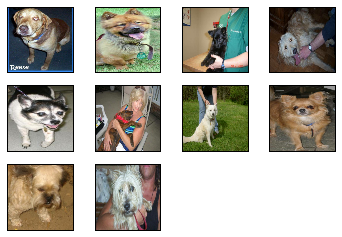

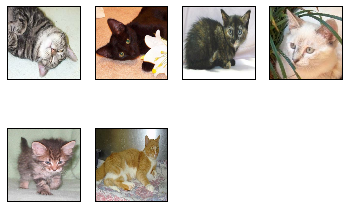

In [3]:
sample_cats = sample_images[sample_labels == 1]
sample_dogs = sample_images[sample_labels == 0]

cat_figure = plt.figure()
for i in range(len(sample_cats)):
    sub = cat_figure.add_subplot(ceil(len(sample_cats)/4), 4, i+1)
    
    # disable axes markings
    sub.set_xticks(())
    sub.set_yticks(())
    
    sub.imshow(sample_cats[i].reshape(dataset.image_dim(include_channels=True)))
cat_figure.show()

dog_figure = plt.figure()
for i in range(len(sample_dogs)):
    sub = dog_figure.add_subplot(ceil(len(sample_dogs)/4), 4, i+1)
    
    # disable axes markings
    sub.set_xticks(())
    sub.set_yticks(())
    
    sub.imshow(sample_dogs[i].reshape(dataset.image_dim(include_channels=True)))
dog_figure.show()

### Predict All Dogs
To provide a baseline for comparison (and to check the composition of our data is ok following the train/validation/test split), I check the performance of a predictor which labels every image as a dog. (And indeed this predictor gets about 50% accuracy as expected.)

In [4]:
def all_dog_inference_op(images):
    return tf.Variable(trainable=False, dtype=tf.float32, initial_value=tf.ones(shape=[images.shape[1]], dtype=tf.float32))

tf.reset_default_graph()

valid_images, valid_labels = dataset.inputs(name='validation', num_epochs=None)
valid_logits = all_dog_inference_op(valid_images)
valid_accuracy_op = tfu.accuracy_op(valid_logits, valid_labels, name='validation')
    
test_images, test_labels = dataset.inputs(name='test', num_epochs=None)
test_logits = all_dog_inference_op(test_images)
test_accuracy_op = tfu.accuracy_op(test_logits, test_labels, name='test')

init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

sess.run(init_op)
    
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess=sess, coord=coord)

try:
    valid_accuracy = tfu.avg_op(sess, valid_accuracy_op)
    print('Validation accuracy: {acc:.1%}'.format(acc=valid_accuracy))
    test_accuracy = tfu.avg_op(sess, test_accuracy_op)
    print('Test accuracy: {acc:.1%}'.format(acc=test_accuracy))
except tf.errors.OutOfRangeError:
    pass
finally:
    coord.request_stop()
    
coord.join(threads)
sess.close()

Validation accuracy: 48.6%
Test accuracy: 49.3%
